# *Rijmbijbel*

## STELLING 1: Het rijm is stabieler dan de voorgaande delen in een vers

In [1]:
import pandas as pd
import bambi as bmb #bayesian model-building interface on top of pymc
import arviz as az #exploratory analysis of Bayesian models
import numpy as np 
import os

from sklearn.preprocessing import scale, StandardScaler #feature scaling (i.e., standardizing or normalizing data)

RANDOM_SEED = 8927 #fixed random seed number used to ensure reproducibility of results that depend on random number generation.
rng = np.random.default_rng(RANDOM_SEED)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk", palette='pastel')
plt.style.use("dark_background")
sns.set(style="ticks", context="talk", palette='Greys')
plt.style.use("default")

from matplotlib import font_manager
font_dirs = ["/data/Alegreya"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams["font.family"] = "Alegreya"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data importeren - alignering met CollateX en Needleman-Wunch

In [8]:
df = pd.read_csv('../data/matches_rijmbijbel/matches_cx.csv', header=0)
df2 = pd.read_csv('../data/matches_rijmbijbel/matches_nw.csv', header=0)
df = df.rename(columns={'relative position': 'rel_vpos'})
df = df[df['id_ms'] != 'sample3_17539a']
df = df[df['id_ms'] != 'sample3_17539b']
df = df[df['id_ms'] != 'sample4_23053a']
df = df[df['id_ms'] != 'sample4_23185a']
df = df[df['id_ms'] != 'sample4_23115a']
df = df[df['id_ms'] != 'sample4_23115b']
df = df[df['id_ms'] != 'sample4_23147a'] 	
df = df.rename(columns={'relative position': 'rel_vpos'})
df2 = df2.rename(columns={'relative position': 'rel_vpos'})
df2 = df2[df2['id_ms'] != 'sample3_17539a']
df2 = df2[df2['id_ms'] != 'sample3_17539b']
df2 = df2[df2['id_ms'] != 'sample4_23053a']
df2 = df2[df2['id_ms'] != 'sample4_23185a']
df2 = df2[df2['id_ms'] != 'sample4_23115a']
df2 = df2[df2['id_ms'] != 'sample4_23115b']
df2 = df2[df2['id_ms'] != 'sample4_23147a'] 
df.head(60)

#print(df[df['id_ms']])
print(f"df shape: {df.shape}")
print(f"df2 shape: {df2.shape}")
print(f"df mismatch mean: {df['mismatch'].mean():.4f}")
print(f"df2 mismatch mean: {df2['mismatch'].mean():.4f}")

/var/folders/89/sc9w1s4j7bj3mnpg0464nr1h0000gn/T/ipykernel_28032/3687863203.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/matches_rijmbijbel/matches_cx.csv', header=0)
/var/folders/89/sc9w1s4j7bj3mnpg0464nr1h0000gn/T/ipykernel_28032/3687863203.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('../data/matches_rijmbijbel/matches_nw.csv', header=0)


df shape: (2850037, 12)
df2 shape: (2907250, 12)
df mismatch mean: 0.1731
df2 mismatch mean: 0.1750


In [11]:
# Direct uit de data
print(f"Gemiddelde kans op mismatch (lemma-niveau): {df['mismatch'].mean():.3f} ({df['mismatch'].mean()*100:.1f}%)")
print(f"Gemiddelde kans op mismatch (lemma-niveau): {df2['mismatch'].mean():.3f} ({df2['mismatch'].mean()*100:.1f}%)")

Gemiddelde kans op mismatch (lemma-niveau): 0.173 (17.3%)
Gemiddelde kans op mismatch (lemma-niveau): 0.175 (17.5%)


## Spellingvariatie: vergelijking op tekenniveau

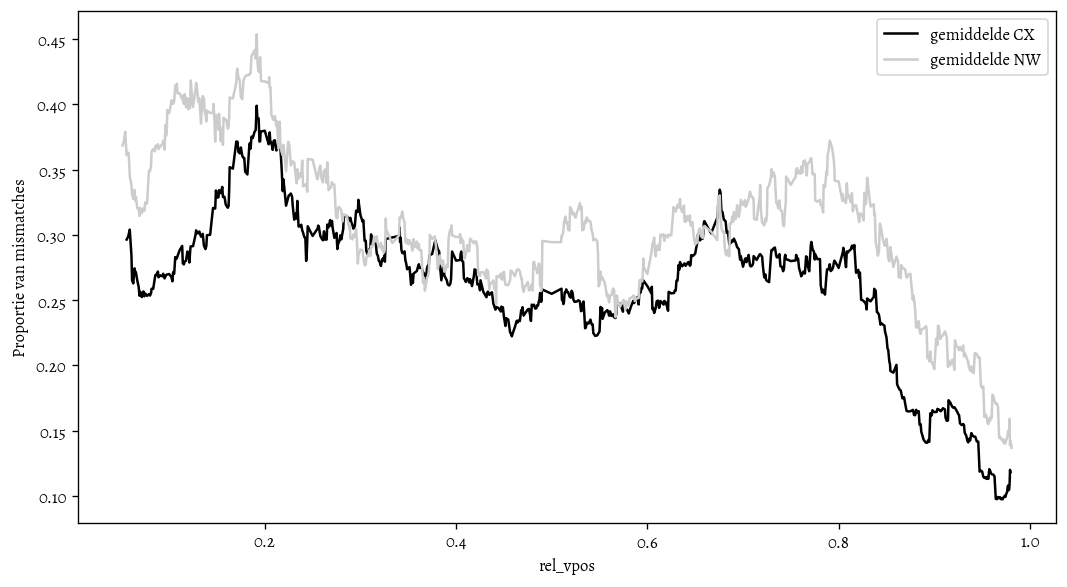

In [12]:
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'DejaVu Sans:italic'
rcParams['mathtext.rm'] = 'DejaVu Sans'
rcParams['font.family'] = 'Alegreya'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'Alegreya:italic'
rcParams['mathtext.rm'] = 'Alegreya'

from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'DejaVu Sans:italic'
rcParams['mathtext.rm'] = 'DejaVu Sans'
rcParams['font.family'] = 'Alegreya'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'Alegreya:italic'
rcParams['mathtext.rm'] = 'Alegreya'
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
rolling_window = df.groupby('rel_vpos')['mismatch'].mean().rolling(window=40).mean()
rolling_window2 = df2.groupby('rel_vpos')['mismatch'].mean().rolling(window=40).mean()
rolling_window.plot(ax=ax, label="gemiddelde CX", color='black')
rolling_window2.plot(ax=ax, label="gemiddelde NW", color='#cccccc')
ax.set_ylabel('Proportie van mismatches')
plt.legend()
plt.tight_layout()
plt.savefig('../data/figures_rijmbijbel/rolling_window_mismatch_proportion.png')

### Verdelen in kwantielen - bayesiaans regressiemodel

In [14]:
df['q_pos'], bins = pd.qcut(df['rel_vpos'], q=6, retbins=True)
df['q_pos'].value_counts()

q_pos
(0.316, 0.483]     478799
(-0.001, 0.148]    475703
(0.65, 0.816]      475446
(0.148, 0.316]     474335
(0.816, 0.98]      474118
(0.483, 0.65]      471636
Name: count, dtype: int64

In [26]:
import pytensor
pytensor.config.cxx = ""

import bambi as bmb
import pymc as pm
import arviz as az
df['q_pos'], bins = pd.qcut(df['rel_vpos'], q=6, retbins=True)
df['q_pos'].value_counts()

df_sample = df.sample(10000)
pos_model = bmb.Model('mismatch ~ q_pos', df_sample, family='bernoulli')

pos_fit = pos_model.fit(draws=1000, chains=4)

Modeling the probability that mismatch==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, q_pos]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.


In [28]:
az.summary(pos_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.448,0.064,-1.573,-1.333,0.002,0.001,1509.0,2104.0,1.0
"q_pos[(0.148, 0.316]]",-0.008,0.088,-0.169,0.155,0.002,0.001,2051.0,2381.0,1.0
"q_pos[(0.316, 0.483]]",0.042,0.086,-0.119,0.205,0.002,0.001,1892.0,2623.0,1.0
"q_pos[(0.483, 0.65]]",-0.044,0.088,-0.200,0.123,0.002,0.001,1855.0,2439.0,1.0
"q_pos[(0.65, 0.816]]",-0.075,0.091,-0.241,0.100,0.002,0.001,2128.0,2491.0,1.0
"q_pos[(0.816, 0.98]]",-0.822,0.104,-1.016,-0.627,0.002,0.002,1936.0,2650.0,1.0


/Users/sofiemoors/miniconda3/lib/python3.10/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: q_pos


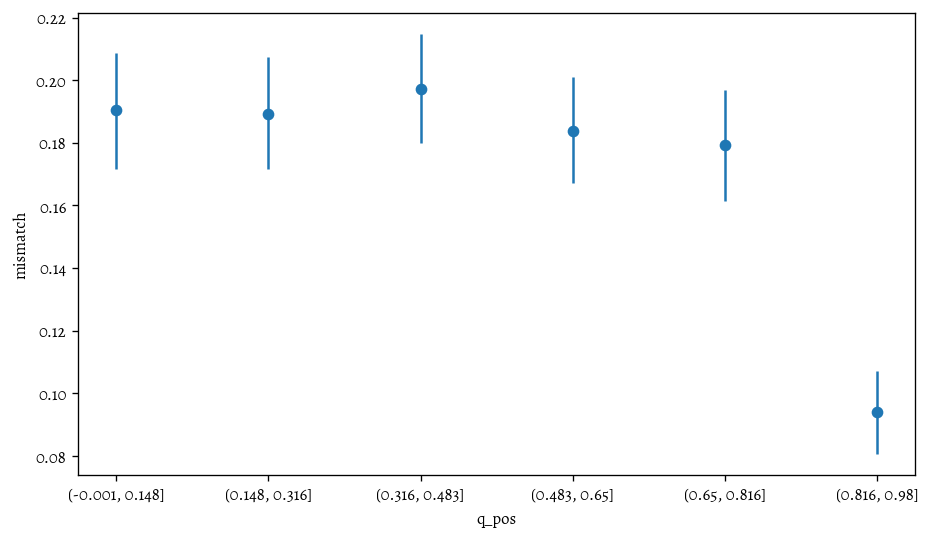

In [29]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
bmb.interpret.plot_predictions(pos_model, pos_fit, ["q_pos"], ax=ax);
plt.savefig('../data/figures_rijmbijbel/bmbmodel.png')

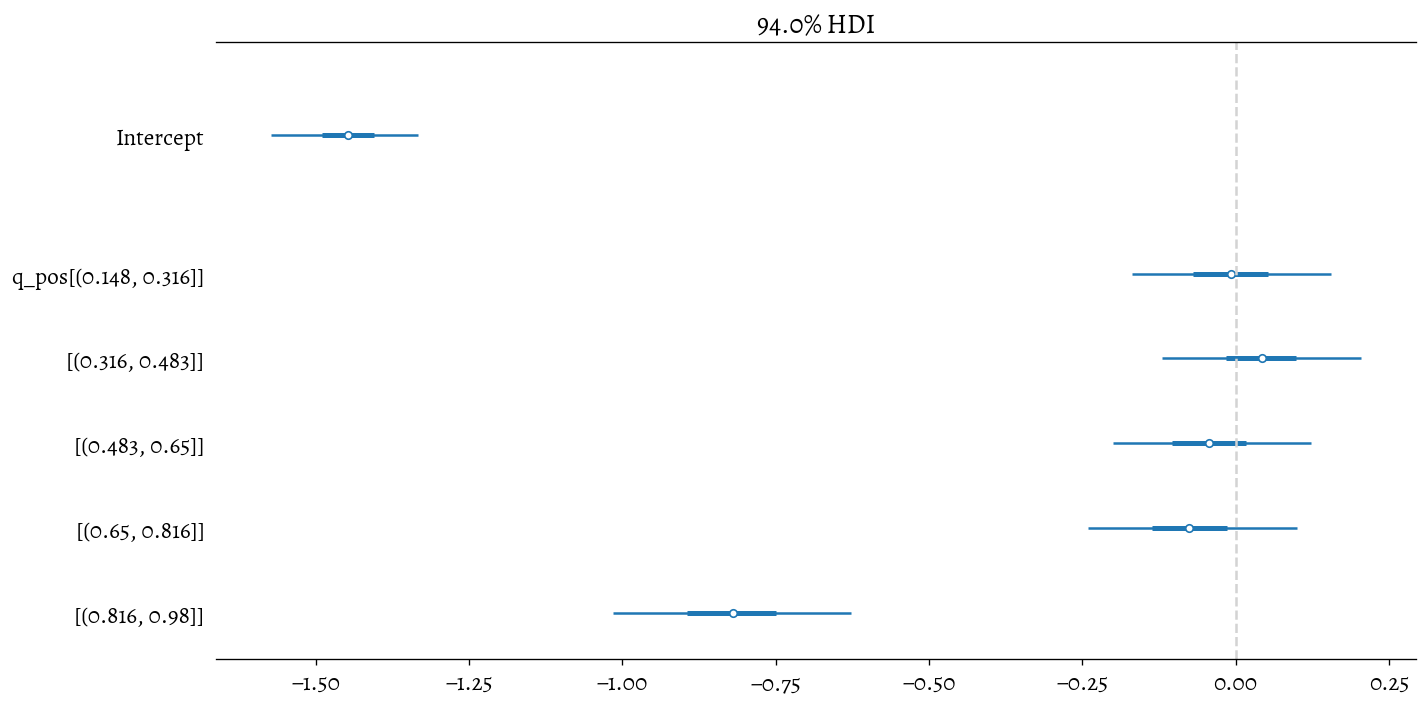

In [30]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)
az.plot_forest(pos_fit, combined=True, figsize=(12, 6), ax=ax)
plt.axvline(0, c='lightgrey', ls='--');
plt.tight_layout()
plt.savefig('../data/figures_rijmbijbel/forestplot.png')

## Lexicale variatie: vergelijking op lemmaniveau

In [35]:
df = pd.read_csv('../data/matches_rijmbijbel/matches_lemma_cx.csv', header=0)
df2 = pd.read_csv('../data/matches_rijmbijbel/matches_lemma_nw.csv', header=0)
df = df.rename(columns={'relative position': 'rel_vpos'})
df2 = df2.rename(columns={'relative position': 'rel_vpos'})

# Filter df
df = df[df['id_ms'] != 'M3_39_508']
df = df[df['id_ms'] != 'M1_75_976']
df = df[df['id_ms'] != 'M1_01_000']
df = df[df['id_ms'] != 'M2_01_000']
df = df[df['id_ms'] != 'M3_01_000']
df = df[df['id_ms'] != 'M2_26_339']
df = df[df['line1'] != 'dominus']
df = df[df['line2'] != 'dominus']

# Filter df2 
df2 = df2[df2['id_ms'] != 'M3_39_508']
df2 = df2[df2['id_ms'] != 'M1_75_976']
df2 = df2[df2['id_ms'] != 'M1_01_000']
df2 = df2[df2['id_ms'] != 'M2_01_000']
df2 = df2[df2['id_ms'] != 'M3_01_000']
df2 = df2[df2['id_ms'] != 'M2_26_339']
df2 = df2[df2['line1'] != 'dominus']
df2 = df2[df2['line2'] != 'dominus']

print(f"df shape: {df.shape}")
print(f"df2 shape: {df2.shape}")
print(f"df mismatch mean: {df['mismatch'].mean():.4f}")
print(f"df2 mismatch mean: {df2['mismatch'].mean():.4f}")

print(df)
print(df2)

/var/folders/89/sc9w1s4j7bj3mnpg0464nr1h0000gn/T/ipykernel_28032/1017371512.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/matches_rijmbijbel/matches_lemma_cx.csv', header=0)
/var/folders/89/sc9w1s4j7bj3mnpg0464nr1h0000gn/T/ipykernel_28032/1017371512.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('../data/matches_rijmbijbel/matches_lemma_nw.csv', header=0)


df shape: (577605, 14)
df2 shape: (577381, 14)
df mismatch mean: 0.2760
df2 mismatch mean: 0.2756
       ms1 ms2        text         id_ms text_part verse  rel_vpos  mismatch  \
0        A   B  Rijmbijbel  sample1_0627   sample1   627  0.000000         0   
1        A   B  Rijmbijbel  sample1_0627   sample1   627  0.166667         0   
2        A   B  Rijmbijbel  sample1_0627   sample1   627  0.333333         0   
3        A   B  Rijmbijbel  sample1_0627   sample1   627  0.500000         1   
4        A   B  Rijmbijbel  sample1_0627   sample1   627  0.666667         0   
...     ..  ..         ...           ...       ...   ...       ...       ...   
577600   N   O  Rijmbijbel  sample2_7430   sample2  7430  0.285714         0   
577601   N   O  Rijmbijbel  sample2_7430   sample2  7430  0.428571         0   
577602   N   O  Rijmbijbel  sample2_7430   sample2  7430  0.571429         0   
577603   N   O  Rijmbijbel  sample2_7430   sample2  7430  0.714286         0   
577604   N   O  Rijmbi

In [36]:
unieke_combinaties = df2.groupby(['id_ms', 'ms1', 'ms2']).ngroups
print(unieke_combinaties)
print(f"Gemiddelde kans op mismatch (lemma-niveau): {df['mismatch'].mean():.3f} ({df['mismatch'].mean()*100:.1f}%)")

96972
Gemiddelde kans op mismatch (lemma-niveau): 0.276 (27.6%)


=== VERDELING ===
is_last_word
False    480633
True      96972
Name: count, dtype: int64
is_first_word
False    480633
True      96972
Name: count, dtype: int64

=== MISMATCH RATE ===
Overige woorden         0.289002
Laatste woord (rijm)    0.211783
Name: mismatch, dtype: float64


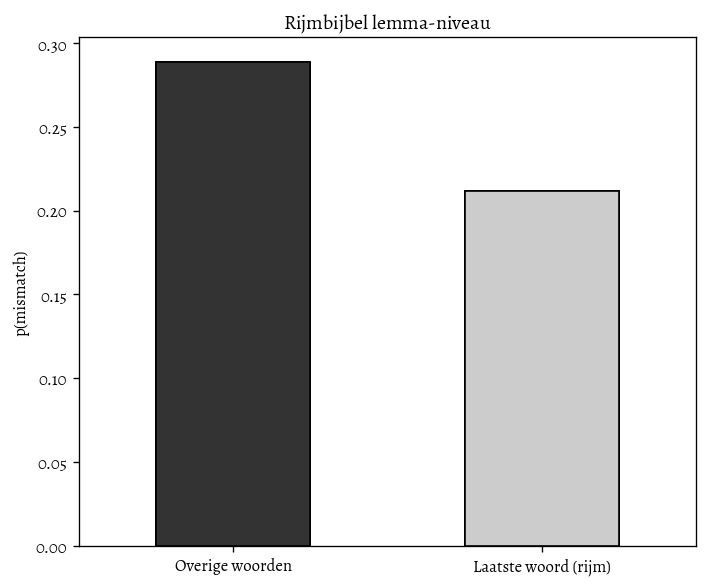


Mann-Whitney U test: p = 0.00e+00
Verschil: 0.077 (26.7% minder)


In [37]:
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'DejaVu Sans:italic'
rcParams['mathtext.rm'] = 'DejaVu Sans'
rcParams['font.family'] = 'Alegreya'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'Alegreya:italic'
rcParams['mathtext.rm'] = 'Alegreya'

max_pos_per_pair = df.groupby(['id_ms', 'ms1', 'ms2'])['rel_vpos'].transform('max')
min_pos_per_pair = df.groupby(['id_ms', 'ms1', 'ms2'])['rel_vpos'].transform('min')

df['is_last_word'] = df['rel_vpos'] == max_pos_per_pair
df['is_first_word'] = df['rel_vpos'] == min_pos_per_pair

print("=== VERDELING ===")
print(df['is_last_word'].value_counts())
print(df['is_first_word'].value_counts())

print("\n=== MISMATCH RATE ===")
comparison = df.groupby('is_last_word')['mismatch'].mean()
comparison.index = ['Overige woorden', 'Laatste woord (rijm)']
print(comparison)

fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
comparison.plot.bar(ax=ax, color=['#7fbfbf', '#ff9999'], edgecolor='black')
comparison.plot.bar(ax=ax, color=['#7fbfbf', '#feffb3'], edgecolor='black')
comparison.plot.bar(ax=ax, color=['#333333', '#cccccc'], edgecolor='black')
ax.set_ylabel('p(mismatch)')
ax.set_xlabel('')
plt.xticks(rotation=0)
ax.set_title('$\mathit{Rijmbijbel}$ lemma-niveau')
plt.tight_layout()
plt.savefig('../data/figures_rijmbijbel/rijmwoord_vs_rest.png', dpi=300)
plt.show()

from scipy import stats

last_word = df[df['is_last_word'] == True]['mismatch']
other_words = df[df['is_last_word'] == False]['mismatch']

stat, p_value = stats.mannwhitneyu(last_word, other_words)
print(f"\nMann-Whitney U test: p = {p_value:.2e}")
print(f"Verschil: {(other_words.mean() - last_word.mean()):.3f} ({((other_words.mean() - last_word.mean()) / other_words.mean() * 100):.1f}% minder)")

### Inclusief eerste woord van het vers

=== VERDELING ===
word_position
midden                  383661
eerste woord             96972
laatste woord (rijm)     96972
Name: count, dtype: int64

=== MISMATCH RATE ===
word_position
eerste woord            0.238151
midden                  0.301855
laatste woord (rijm)    0.211783
Name: mismatch, dtype: float64


/var/folders/89/sc9w1s4j7bj3mnpg0464nr1h0000gn/T/ipykernel_28032/3312621414.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comparison = df.groupby('word_position')['mismatch'].mean()


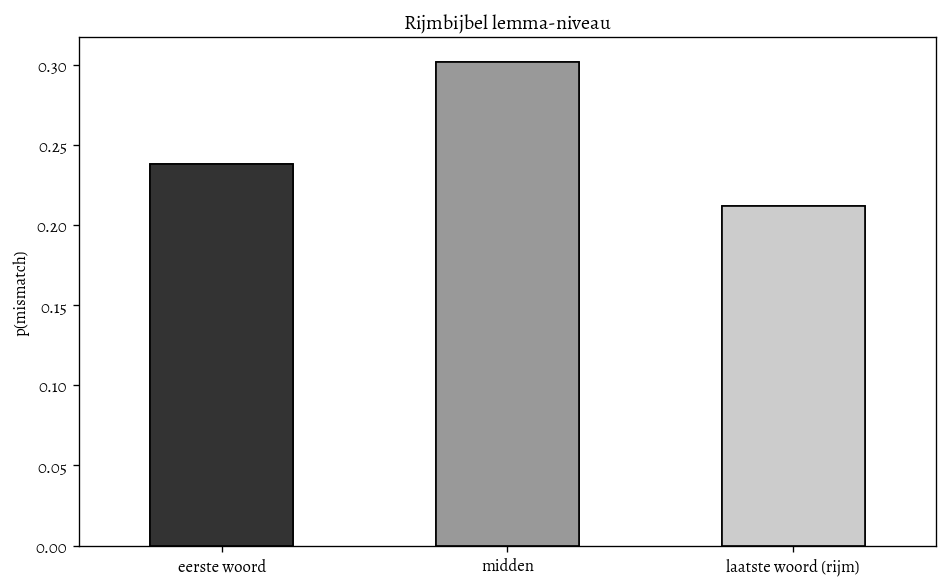


=== STATISTISCHE TESTS ===
Eerste woord:        23.8%
Midden:              30.2%
Laatste woord (rijm): 21.2%

Eerste vs Midden: p = 0.00e+00
  Verschil: 6.4 procentpunt

Midden vs Laatste: p = 0.00e+00
  Verschil: 9.0 procentpunt

Eerste vs Laatste: p = 5.90e-44
  Verschil: 2.6 procentpunt

=== EFFECTGROOTTES (Cohen's h) ===
Eerste vs Midden:  -0.144
Midden vs Laatste: 0.207
Eerste vs Laatste: 0.063


In [39]:
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'DejaVu Sans:italic'
rcParams['mathtext.rm'] = 'DejaVu Sans'
rcParams['font.family'] = 'Alegreya'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'Alegreya:italic'
rcParams['mathtext.rm'] = 'Alegreya'

max_pos_per_pair = df.groupby(['id_ms', 'ms1', 'ms2'])['rel_vpos'].transform('max')
min_pos_per_pair = df.groupby(['id_ms', 'ms1', 'ms2'])['rel_vpos'].transform('min')

df['is_last_word'] = df['rel_vpos'] == max_pos_per_pair
df['is_first_word'] = df['rel_vpos'] == min_pos_per_pair

df['word_position'] = 'midden'
df.loc[df['is_first_word'], 'word_position'] = 'eerste woord'
df.loc[df['is_last_word'], 'word_position'] = 'laatste woord (rijm)'

df['word_position'] = pd.Categorical(
    df['word_position'], 
    categories=['eerste woord', 'midden', 'laatste woord (rijm)'], 
    ordered=True
)

print("=== VERDELING ===")
print(df['word_position'].value_counts())

print("\n=== MISMATCH RATE ===")
comparison = df.groupby('word_position')['mismatch'].mean()
print(comparison)

fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
comparison.plot.bar(ax=ax, color=['#7fbfbf', '#a8d5ba', '#feffb3'], edgecolor='black')
comparison.plot.bar(ax=ax, color=['#333333', '#999999', '#cccccc'], edgecolor='black')
ax.set_ylabel('p(mismatch)')
ax.set_xlabel('')
plt.xticks(rotation=0)
ax.set_title('$\mathit{Rijmbijbel}$ lemma-niveau')
plt.tight_layout()
plt.savefig('../data/figures_rijmbijbel/woordpositie_drie_categorieen.png', dpi=300)
plt.show()

# Statistische tests
from scipy import stats

eerste = df[df['word_position'] == 'eerste woord']['mismatch']
midden = df[df['word_position'] == 'midden']['mismatch']
laatste = df[df['word_position'] == 'laatste woord (rijm)']['mismatch']

print("\n=== STATISTISCHE TESTS ===")
print(f"Eerste woord:        {eerste.mean()*100:.1f}%")
print(f"Midden:              {midden.mean()*100:.1f}%")
print(f"Laatste woord (rijm): {laatste.mean()*100:.1f}%")

# Test eerste vs midden
stat, p_value = stats.mannwhitneyu(eerste, midden)
print(f"\nEerste vs Midden: p = {p_value:.2e}")
print(f"  Verschil: {(midden.mean() - eerste.mean())*100:.1f} procentpunt")

# Test midden vs laatste
stat, p_value = stats.mannwhitneyu(midden, laatste)
print(f"\nMidden vs Laatste: p = {p_value:.2e}")
print(f"  Verschil: {(midden.mean() - laatste.mean())*100:.1f} procentpunt")

# Test eerste vs laatste
stat, p_value = stats.mannwhitneyu(eerste, laatste)
print(f"\nEerste vs Laatste: p = {p_value:.2e}")
print(f"  Verschil: {(eerste.mean() - laatste.mean())*100:.1f} procentpunt")

# Effectgroottes (Cohen's h)
import numpy as np

def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

print("\n=== EFFECTGROOTTES (Cohen's h) ===")
print(f"Eerste vs Midden:  {cohens_h(eerste.mean(), midden.mean()):.3f}")
print(f"Midden vs Laatste: {cohens_h(midden.mean(), laatste.mean()):.3f}")
print(f"Eerste vs Laatste: {cohens_h(eerste.mean(), laatste.mean()):.3f}")